In [3]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import networkx as nx
from skimage import color
from sklearn.feature_extraction import image
import math
import pandas as pd

In [4]:
oval_data = pd.read_csv('oval-1.csv', delimiter=',')
oval_data = oval_data.to_numpy()
box_data = pd.read_csv('box.csv',delimiter=',')
box_data = box_data.to_numpy()
example_df = pd.DataFrame([[100, 120, 120],
                           [90, 100, 130],
                           [80, 85, 125]])

In [5]:
from PIL import Image
# Open the image
image_path = "Pelican.jpg"  # Replace with your image path
img = Image.open(image_path)

# Convert image to grayscale
grayscale_img = img.convert("L")

# Get pixel values as a 2D array
pixel_table = list(grayscale_img.getdata())
width, height = grayscale_img.size
pixel_table = [pixel_table[i * width:(i + 1) * width] for i in range(height)]

swan_data = pd.DataFrame(pixel_table)
swan_data = swan_data.to_numpy()

In [21]:
import gurobipy as gp
import numpy as np
import math
import matplotlib.pyplot as plt

# Function to calculate similarity between two pixels
def calculate_similarity(Ii, Ij, sigma):
    similarity = 100 * math.exp(-((Ii - Ij) ** 2) / (2 * sigma ** 2))
    return math.ceil(similarity)

# Create a function for generating the network matrix with dynamic source/sink
def create_network_matrix_dynamic(intensity_matrix, sigma, background_threshold, foreground_threshold, diagnoal = False):
    image_size = intensity_matrix.shape[0]
    num_nodes = image_size * image_size + 2  # Including source and sink
    network = np.zeros((num_nodes, num_nodes))

    # Compute similarities and fill network
    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            Ii = intensity_matrix[i, j]

            # Horizontal neighbors
            if j < image_size - 1:
                Ij = intensity_matrix[i, j + 1]
                similarity = calculate_similarity(Ii, Ij, sigma)
                network[pixel, pixel + 1] = similarity
                network[pixel + 1, pixel] = similarity

            # Vertical neighbors
            if i < image_size - 1:
                Ij = intensity_matrix[i + 1, j]
                similarity = calculate_similarity(Ii, Ij, sigma)
                network[pixel, pixel + image_size] = similarity
                network[pixel + image_size, pixel] = similarity

            if diagnoal:
                # Diagonal neighbors
                if i < image_size - 1 and j < image_size - 1:
                    Ij = intensity_matrix[i + 1, j + 1]
                    similarity = calculate_similarity(Ii, Ij, sigma)
                    network[pixel, pixel + image_size + 1] = similarity
                    network[pixel + image_size + 1, pixel] = similarity

    # Add connections for the source (background) and sink (foreground) dynamically
    source_node = num_nodes - 2
    sink_node = num_nodes - 1

    for i in range(image_size):
        for j in range(image_size):
            pixel = i * image_size + j
            pixel_intensity = intensity_matrix[i, j]

            if pixel_intensity < background_threshold:
                network[source_node, pixel] = 100  # Strong connection to source
            elif pixel_intensity > foreground_threshold:
                network[pixel, sink_node] = 100  # Strong connection to sink

    return network, source_node, sink_node

# Function to add flow conservation constraints
def add_flow_conservation_constraints(mod, flow, num_nodes, source_node, sink_node):
    for node in range(num_nodes):
        if node not in [source_node, sink_node]:
            mod.addConstr(flow[:, node].sum() == flow[node, :].sum(), name=f"flow_conservation_{node}")

# Function to perform DFS for cut identification
def depth_first_search(residual_network, source_node):
    num_nodes = residual_network.shape[0]
    visited = np.zeros(num_nodes, dtype=bool)

    def dfs(node):
        visited[node] = True
        print(f"Visiting node: {node}")
        for neighbor in range(num_nodes):
            if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                dfs(neighbor)

    dfs(source_node)
    return visited

def iterative_dfs(residual_network, source_node):
    num_nodes = residual_network.shape[0]
    visited = np.zeros(num_nodes, dtype=bool)
    stack = [source_node]  # Start DFS from the source node

    while stack:
        node = stack.pop()  # Take a node from the stack
        visited[node] = True
        for neighbor in range(num_nodes):
            if residual_network[node, neighbor] > 0 and not visited[neighbor]:
                stack.append(neighbor)  # Add unvisited neighbors to the stack

    return visited

# Function to calculate max flow and residual network
def max_flow(network, intensity_matrix, source_node, sink_node):
    num_nodes = network.shape[0]
    image_size = intensity_matrix.shape[0]

    # Create Gurobi model
    mod = gp.Model("ImageSegnemtation")
    flow = mod.addMVar((num_nodes, num_nodes), ub=network, vtype=gp.GRB.CONTINUOUS, name="flow")
    mod.setObjective(flow[source_node, :].sum(), gp.GRB.MAXIMIZE)

    # Add flow conservation constraints
    add_flow_conservation_constraints(mod, flow, num_nodes, source_node, sink_node)

    mod.Params.OutputFlag = 0  # Silence Gurobi output
    mod.optimize()
    # mod.Params.MemLimit = 2048  # Limit memory to 2GB

    if mod.status == gp.GRB.OPTIMAL:
        print("Optimal solution found")
        flow_solution = flow.X

        # Calculate residual network
        residual_network = network - flow_solution

        # Perform DFS to find accessible nodes
        visited = iterative_dfs(residual_network, source_node)

        # Find the cut edges
        cut_edges = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if visited[i] and not visited[j] and network[i, j] > 0:
                    cut_edges.append((i, j))

        return cut_edges
    else:
        print("No optimal solution found")
        return None

# Function to visualize the segmentation with proper boundary cuts only
def visualize_segmentation_proper(cut_edges, intensity_matrix):
    image_size = intensity_matrix.shape[0]
    plt.imshow(intensity_matrix, cmap='gray', vmin=0, vmax=1)

    # Overlay boundary cuts in red with adjusted coordinates (0.5 offset)
    for i, j in cut_edges:
        if i < image_size * image_size and j < image_size * image_size:
            row_i, col_i = divmod(i, image_size)
            row_j, col_j = divmod(j, image_size)

            # Ensure we only plot boundaries between accessible and inaccessible regions
            # plt.plot([col_i - 0.5, col_j - 0.5], [row_i + 0.5, row_j + 0.5], color='red', linewidth=2)
            plt.plot([col_i, col_j], [row_i, row_j], color='red', linewidth=1)

    plt.title("Segmented Image with Boundary Cuts")
    plt.colorbar(label='Intensity')
    plt.show()

# Full function to handle the segmentation pipeline
def segment_image(pixel_data, sigma, background_threshold, foreground_threshold):
    # Create network matrix with dynamic source/sink assignment
    network, source_node, sink_node = create_network_matrix_dynamic(pixel_data, sigma, background_threshold, foreground_threshold)
    
    # Calculate max flow and find cut edges
    cut_edges = max_flow(network, pixel_data, source_node, sink_node)

    # Visualize segmentation
    if cut_edges is not None:
        visualize_segmentation_proper(cut_edges, pixel_data)


0.1
Optimal solution found


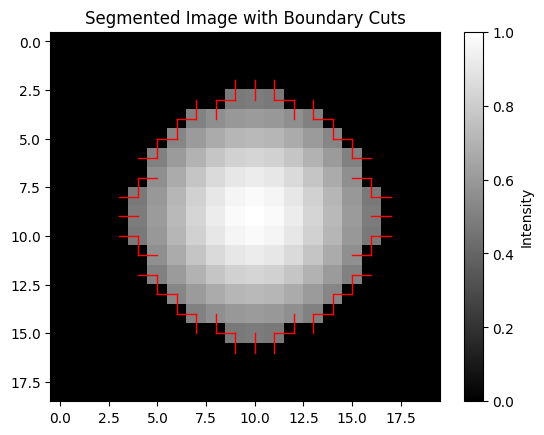

In [22]:

# Example usage with pixel_data, threshold, and sigma
background_threshold = 0.1 * np.max(oval_data)  # 20% of max intensity as background threshold
foreground_threshold = 0.9 * np.max(oval_data)  # 80% of max intensity as foreground threshold
sigma = 0.05  # Experiment with sigma values

print(background_threshold)

segment_image(oval_data, sigma, background_threshold, foreground_threshold)


Optimal solution found


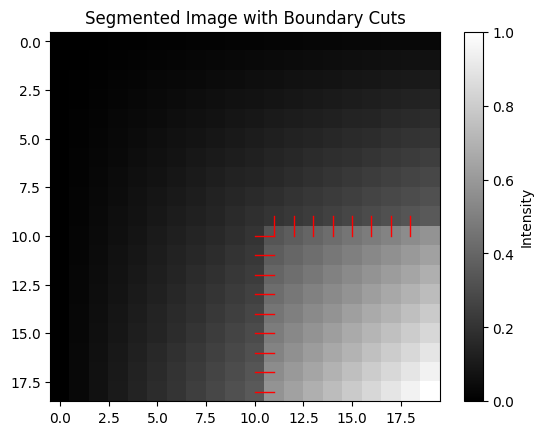

In [16]:
segment_image(box_data, sigma, background_threshold, foreground_threshold)

In [9]:
# segment_image(example_df, sigma, background_threshold, foreground_threshold)

In [10]:
# segment_image(swan_data, sigma, background_threshold, foreground_threshold)